<a href="https://colab.research.google.com/github/TusharJiShukla/CS-307-Lab-Report/blob/main/Lab_8_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class PoissonCache:
    pmf_cache = {}
    sf_cache = {}
    series_cache = {}
    max_cutoff = 25

    @classmethod
    def get_pmf_up_to_cutoff(cls, mean, cutoff):
        assert isinstance(mean, int), "mean should be an integer."
        assert isinstance(cutoff, int), "cutoff should be an integer"

        if (mean, cutoff) not in cls.series_cache:
            cls._compute_and_cache_pmf(mean, cutoff)

        return cls.series_cache[(mean, cutoff)]

    @classmethod
    def _compute_and_cache_pmf(cls, mean, cutoff):
        if mean not in cls.pmf_cache:
            print("Calculate poisson ...")
            cls.pmf_cache[mean] = poisson.pmf(np.arange(cls.max_cutoff + 1), mean)
            cls.sf_cache[mean] = poisson.sf(np.arange(cls.max_cutoff + 1), mean)

        output = np.copy(cls.pmf_cache[mean][:cutoff + 1])
        output[-1] += cls.sf_cache[mean][cutoff]

        cls.series_cache[(mean, cutoff)] = output

In [3]:
class GBikeRentalSolver:
    max_bikes_per_station = 20
    rental_income = 10.
    relocation_cost = 2.
    max_relocations = 5
    overnight_parking_fee = 4.

    penalty_for_invalid_action = 100.

    avg_rentals_station1 = 3
    avg_rentals_station2 = 4
    avg_returns_station1 = 3
    avg_returns_station2 = 2

    discount_rate = 0.9

    policy_eval_tolerance = 0.01

    action_policy = None
    state_values = None

    def __init__(self):
        self.action_policy = np.zeros([self.max_bikes_per_station + 1] * 2, int)
        self.state_values = np.zeros([self.max_bikes_per_station + 1] * 2)

        self.expected_income_station1 = self.compute_expected_rental_income(self.avg_rentals_station1)
        self.expected_income_station2 = self.compute_expected_rental_income(self.avg_rentals_station2)

        assert self.penalty_for_invalid_action >= 0

    def compute_expected_value(self, action, bikes_at_station1, bikes_at_station2):
        trans_prob1 = self.transition_probabilities(
            bikes_at_station1, self.avg_rentals_station1, self.avg_returns_station1, -action
        )
        trans_prob2 = self.transition_probabilities(
            bikes_at_station2, self.avg_rentals_station2, self.avg_returns_station2, action
        )
        trans_prob = np.outer(trans_prob1, trans_prob2)

        return (
            self.expected_income_station1[bikes_at_station1]
            + self.expected_income_station2[bikes_at_station2]
            - self.calculate_relocation_cost(bikes_at_station1, bikes_at_station2, action)
            + self.discount_rate * sum((trans_prob * self.state_values).flat)
        )

    def evaluate_policy(self):
        while True:
            max_diff = 0.
            iterator = np.nditer([self.action_policy], flags=["multi_index"])

            while not iterator.finished:
                action = iterator[0]
                bikes_at_station1, bikes_at_station2 = iterator.multi_index

                temp_value = self.state_values[bikes_at_station1, bikes_at_station2]

                self.state_values[bikes_at_station1, bikes_at_station2] = self.compute_expected_value(
                    action=action, bikes_at_station1=bikes_at_station1, bikes_at_station2=bikes_at_station2
                )

                max_diff = max(
                    max_diff,
                    abs(self.state_values[bikes_at_station1, bikes_at_station2] - temp_value),
                )

                iterator.iternext()

            print(max_diff)
            if max_diff < self.policy_eval_tolerance:
                break

    def improve_policy(self):
        is_policy_changed = False

        iterator = np.nditer([self.action_policy], flags=["multi_index"])
        while not iterator.finished:
            bikes_at_station1, bikes_at_station2 = iterator.multi_index

            max_val = -1
            best_action = None

            for act in range(-self.max_relocations, self.max_relocations + 1):
                val = self.compute_expected_value(
                    action=act,
                    bikes_at_station1=bikes_at_station1,
                    bikes_at_station2=bikes_at_station2,
                )
                if val > max_val:
                    max_val = val
                    best_action = act

            if self.action_policy[bikes_at_station1, bikes_at_station2] != best_action:
                is_policy_changed = True
                self.action_policy[bikes_at_station1, bikes_at_station2] = best_action

            iterator.iternext()

        return is_policy_changed

    def calculate_relocation_cost(self, bikes_at_station1, bikes_at_station2, action):
        if action == 0:
            return 0.

        if action > 0:
            prob = self.transition_probabilities(
                bikes_at_station1, self.avg_rentals_station1, self.avg_returns_station1
            )
            cost = self.generate_relocation_cost_array(action)
            if action > 10:
                cost += self.overnight_parking_fee * (action - 10)
            return cost.dot(prob)

        prob = self.transition_probabilities(
            bikes_at_station2, self.avg_rentals_station2, self.avg_returns_station2
        )
        cost = self.generate_relocation_cost_array(action)
        if action > 10:
            cost += self.overnight_parking_fee * (action - 10)
        return cost.dot(prob)

    def generate_relocation_cost_array(self, action):
        abs_action = abs(action)

        if abs_action != 0:
            abs_action -= 1

        if self.penalty_for_invalid_action == 0:
            cost = (
                np.asarray(
                    [
                        ii if ii < abs_action else abs_action
                        for ii in range(self.max_bikes_per_station + 1)
                    ]
                )
                * self.relocation_cost
            )
        else:
            cost = (
                np.asarray(
                    [
                        self.penalty_for_invalid_action if ii < abs_action else abs_action
                        for ii in range(self.max_bikes_per_station + 1)
                    ]
                )
                * self.relocation_cost
            )
        return cost

    @classmethod
    def compute_expected_rental_income(cls, expected_rentals):
        return np.asarray(
            [cls.state_rental_income(s, expected_rentals) for s in range(cls.max_bikes_per_station + 1)]
        )

    @classmethod
    def state_rental_income(cls, s, mean):
        rewards = cls.rental_income * np.arange(s + 1)
        prob = PoissonCache.get_pmf_up_to_cutoff(mean, cutoff=s)
        return rewards.dot(prob)

    def transition_probabilities(self, s, rentals, returns, action=0):
        returns_size = self.max_relocations + self.max_bikes_per_station

        prob_rentals = PoissonCache.get_pmf_up_to_cutoff(rentals, s)
        prob_returns = PoissonCache.get_pmf_up_to_cutoff(returns, returns_size)
        prob = np.outer(prob_rentals, prob_returns)

        trans_prob = np.asarray([prob.trace(offset) for offset in range(-s, returns_size + 1)])

        assert abs(action) <= self.max_relocations, "action can be large than %s." % self.max_relocations

        if action == 0:
            trans_prob[20] += sum(trans_prob[21:])
            return trans_prob[:21]

        if action > 0:
            trans_prob[self.max_bikes_per_station - action] += sum(
                trans_prob[self.max_bikes_per_station - action + 1 :]
            )
            trans_prob[self.max_bikes_per_station - action + 1 :] = 0

            return np.roll(trans_prob, shift=action)[: self.max_bikes_per_station + 1]

        action = -action
        trans_prob[action] += sum(trans_prob[:action])
        trans_prob[:action] = 0

        trans_prob[action + self.max_bikes_per_station] += sum(
            trans_prob[action + self.max_bikes_per_station + 1 :]
        )
        trans_prob[action + self.max_bikes_per_station + 1 :] = 0

        return np.roll(trans_prob, shift=-action)[: self.max_bikes_per_station + 1]

    def run_policy_iteration(self):
        self.evaluate_policy()
        while self.improve_policy():
            self.evaluate_policy()

Calculate poisson ...
Calculate poisson ...
Calculate poisson ...
193.3490492751235
134.00426086449983
90.45243773749047
67.59779106615537
53.584930617584064
41.72086291128721
32.72010939685782
26.087556138178172
21.778143392699917
18.31805979033311
15.367406347701888
12.86102712361668
10.739286690815732
8.949004145272568
7.443128433756954
6.180206266078471
5.123897292162269
4.242540347244983
3.5087368683560953
2.8989345554259103
2.393012044082809
1.973873579670851
1.6270638320038415
1.3404108007534319
1.103701663738775
0.9083935811098627
0.747359290960901
0.6146658513105194
0.5053839897123567
0.4154250710594738
0.34140255324280133
0.2805148621151261
0.2304468020147965
0.1892868693017249
0.15545811562594736
0.1276604902645886
0.10482286156803866
0.0860631678041841
0.0706553733336932
0.05800210589359267
0.04761202529920183
0.0390811247288525
0.03207729501582435
0.02632759237292248
0.021607743132562973
0.017733497475092008
0.01455351005540706
0.011943480427248687
0.009801332242659555
53.

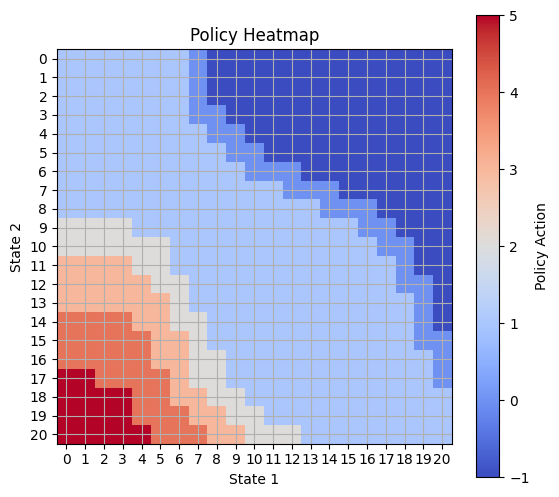

In [4]:
solver = GBikeRentalSolver()

for _ in range(4):
    solver.evaluate_policy()
    solver.improve_policy()

print(solver.action_policy)

plt.figure(figsize=(14, 6))

# Heatmap for policy
plt.subplot(121)
plt.title("Policy Heatmap")
plt.imshow(solver.action_policy, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Policy Action")
plt.xlabel("State 1")
plt.ylabel("State 2")
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid(True)


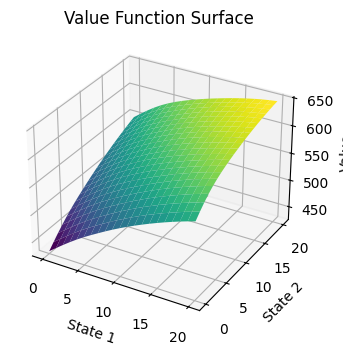

In [5]:
# 3D surface plot for value
X, Y = np.meshgrid(range(21), range(21))
Z = solver.state_values

fig = plt.figure()
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(X, Y, Z, cmap="viridis")
ax.set_title("Value Function Surface")
ax.set_xlabel("State 1")
ax.set_ylabel("State 2")
ax.set_zlabel("Value")

plt.tight_layout()
plt.show()